In [1]:
import os
import dask
import joypy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [96]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr


def joy_div(data,
            time_key='year',
            time_var='time',
            data_key='t_prime',
            decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data[time_var])
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key, data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_filter, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(10, 10))
    plt.xlabel("Effective Latitude [degrees]")
    plt.ylabel("year")
    plt.show()
    plt.savefig('/home/ivanhigueram/public_html/joy_plt_prj.png')
    return data_filter


def overlayed_decades(data,
                      ax=None,
                      model=None,
                      decade=None,
                      grid=False,
                      var='t_prime',
                      clr='blue'):
    
    
    if model is not None:
        data = data[data.model.isin(model)]
        
    if decade is not None:
        data = data[data.decade.isin(decade)]
    
    if grid:
        g = sns.FacetGrid(data, 
                         row="model",
                         col="place",
                         hue="decade", 
                         sharex=True,
                         margin_titles=True
                         )
        g.map(sns.kdeplot,
              "eff_lat_deg",
              shade=True,
              alpha=0.3,
              #Label=str(decade)+'s'
             )
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('Effective Latitude for a set of global locations')
        g.add_legend()
    else:
        data_in_decade = data.loc[(data['model'] == model) &
                                  (data['decade'] == decade), var]

        sns.kdeplot(data_in_decade, 
                    ax=ax,
                    shade=True, 
                    alpha=0.3, 
                    Label=str(decade)+'s',
                    color=clr)

        quantiles = np.quantile(data_in_decade,[0.1,0.9])

        plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
        plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)

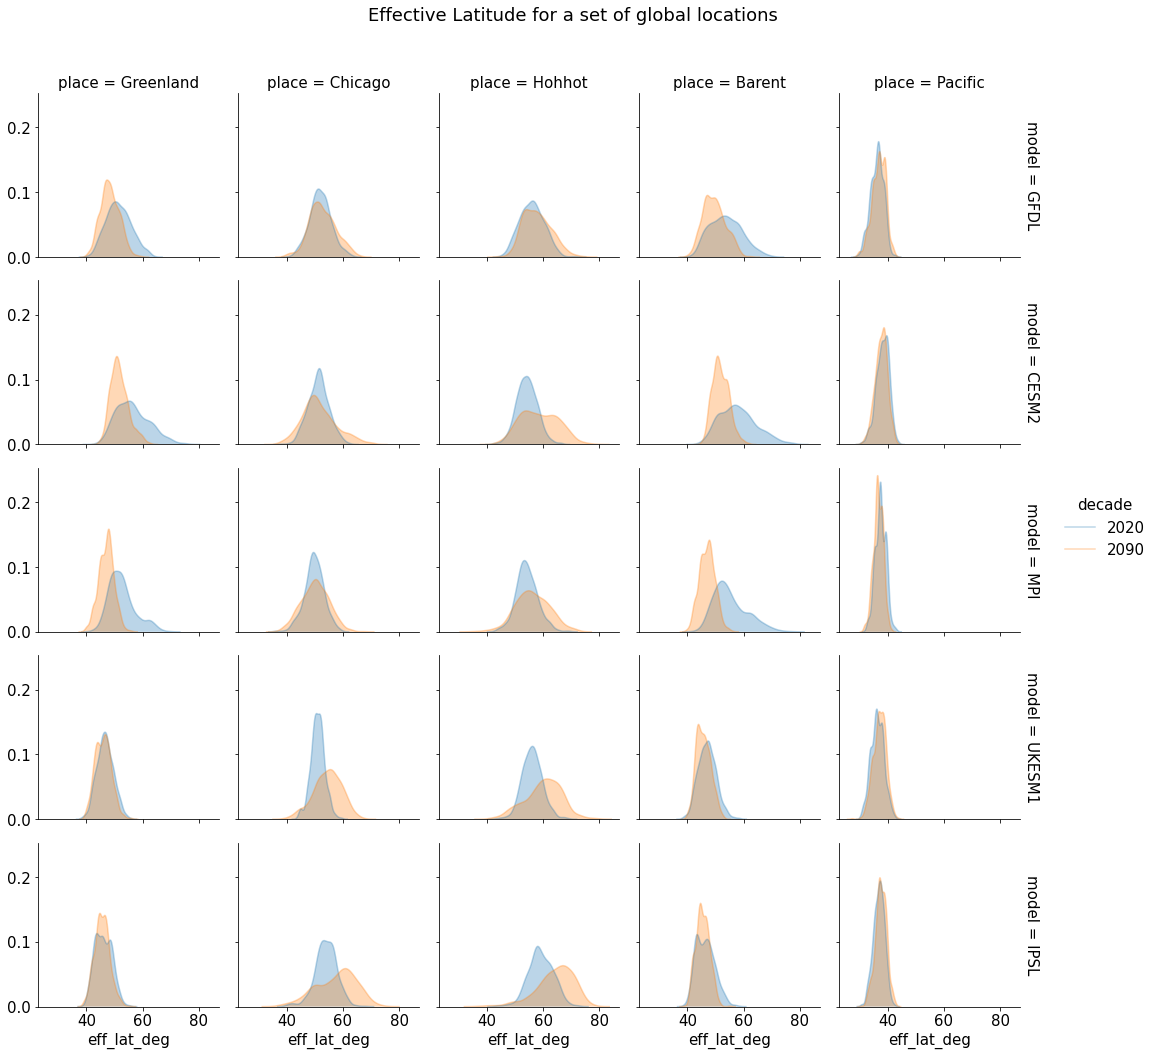

In [97]:
overlayed_decades(eff_lat_all_mods,
                  decade=[2020, 2090],
                  grid=True)

In [87]:
list_df = []
for f in Path('.').glob('*.csv'):
    print(f)
    model_name = f.stem.split('_')[0]
    df = pd.read_csv(f)
    
    df['time'] = pd.to_datetime(df.time, 
                                errors='coerce',
                                utc=True)
    df['model'] = model_name
    df = df[~ df.time.isna()]
    df['decade'] = df.time.dt.year.apply(lambda x: int(x)//10 * 10)
    df['place'] = df.place.str.capitalize()
    
    list_df.append(df)
    
eff_lat_all_mods = pd.concat(list_df)
eff_lat_all_mods_comp = eff_lat_all_mods[
    eff_lat_all_mods.decade.isin([2030, 2090])
]

GFDL_eff_lat.csv
CESM2_eff_lat.csv
MPI_eff_lat.csv
UKESM1_eff_lat.csv
IPSL_eff_lat.csv


Text(0, 0.5, 'Density')

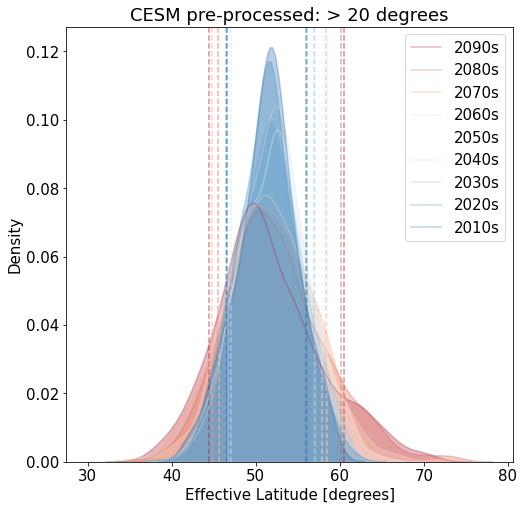

In [31]:
colors = ['#b2182b',
          '#d6604d',
          '#f4a582',
          '#fddbc7',
          '#f7f7f7',
          '#d1e5f0',
          '#92c5de',
          '#4393c3',
          '#2166ac']
years = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

years.reverse()

fig, ax = plt.subplots(figsize=(8, 8))
for decade, color in zip(years, colors):
    overlayed_decades(eff_lat_all_mods, 
                      decade=decade,
                      model='CESM2Test_test',
                      clr=color,
                      ax=ax,
                      var='eff_lat_deg')
plt.title('CESM pre-processed: > 20 degrees')
plt.xlabel("Effective Latitude [degrees]")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

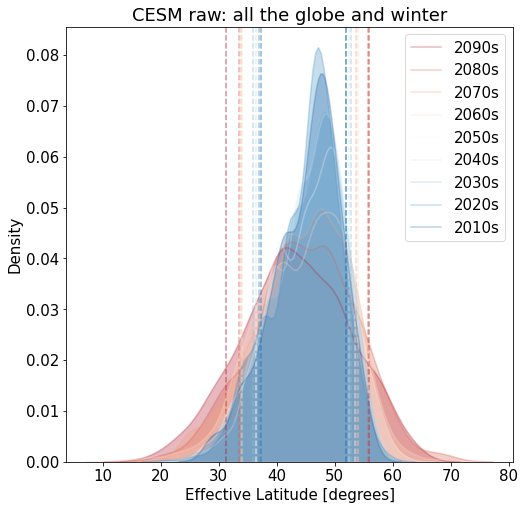

In [34]:
colors = ['#b2182b',
          '#d6604d',
          '#f4a582',
          '#fddbc7',
          '#f7f7f7',
          '#d1e5f0',
          '#92c5de',
          '#4393c3',
          '#2166ac']
years = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

years.reverse()

fig, ax = plt.subplots(figsize=(8, 8))
for decade, color in zip(years, colors):
    overlayed_decades(eff_lat_all_mods, 
                      decade=decade,
                      model='CESM2',
                      clr=color,
                      ax=ax,
                      var='eff_lat_deg')
plt.xlabel("Effective Latitude [degrees]")
plt.title('CESM raw: all the globe and winter')
plt.ylabel("Density")

In [37]:
pivot_test  = eff_lat_all_mods.filter(['decade', 'model', 'eff_lat_deg', 'time']).\
pivot(index=['decade', 'time'], columns='model', values='eff_lat_deg').reset_index()
pivot_test

model,decade,time,CESM2,CESM2Test_test,CESM2v0.1,GFDL,IPSL,MPI,UKESM1
0,2010,2015-01-01 00:00:00+00:00,49.548215,53.491821,53.491821,NaN,NaN,NaN,NaN
1,2010,2015-01-01 12:00:00+00:00,NaN,NaN,NaN,46.832577,53.925130,42.586269,45.983551
2,2010,2015-01-02 00:00:00+00:00,49.815202,53.726817,53.726817,NaN,NaN,NaN,NaN
3,2010,2015-01-02 12:00:00+00:00,NaN,NaN,NaN,49.770254,52.550000,39.030585,48.625908
4,2010,2015-01-03 00:00:00+00:00,47.448761,51.733472,51.733472,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15497,2100,2100-12-30 00:00:00+00:00,41.669904,49.964452,49.964452,NaN,NaN,NaN,NaN
15498,2100,2100-12-30 12:00:00+00:00,NaN,NaN,NaN,53.594060,61.407925,38.103367,50.604281
15499,2100,2100-12-31 00:00:00+00:00,46.305875,52.736724,52.736724,NaN,NaN,NaN,NaN
15500,2100,2100-12-31 12:00:00+00:00,NaN,NaN,NaN,53.443302,62.533000,38.394757,NaN


Text(0, 0.5, 'Global Climate Model')

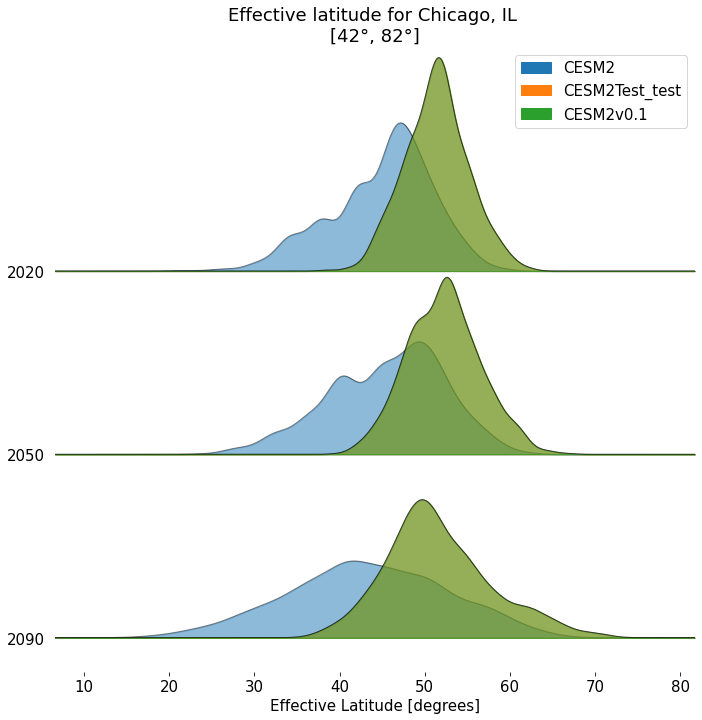

In [41]:
from matplotlib import cm
fig, axes = joypy.joyplot(pivot_test[pivot_test.decade.isin([2020, 2050, 2090])],
                          fill=True,
                          legend=True,
                          #fade=True,
                          linewidth=1,
                          alpha=0.5,
                          figsize=(10, 10),
                          #range_style='own',
                          by="decade",
                          title="Effective latitude for Chicago, IL \n[42°, 82°]",
                          column=['CESM2','CESM2Test_test','CESM2v0.1']
                          #column=['CESM2','GFDL','IPSL','MPI','UKESM1'],
                          #color=["grey","salmon","tomato"]
                         )
plt.xlabel("Effective Latitude [degrees]")
plt.ylabel("Global Climate Model")

In [ ]:
 colors = ['#1b9e77',
          '#d95f02',
          #'#7570b3',
          #'#e7298a',
          '#66a61e'
        ]
models = eff_lat_all_mods_comp.model.unique()

fig, ax = plt.subplots(figsize=(8, 8))
for model, color in zip(models, colors):
    overlayed_decades(eff_lat_all_mods_comp, 
                      model,
                      decade=2090,
                      clr=color, 
                      ax=ax,
                      var='eff_lat_deg')
plt.xlabel("Effective Latitude [degrees]")
plt.ylabel("Density")

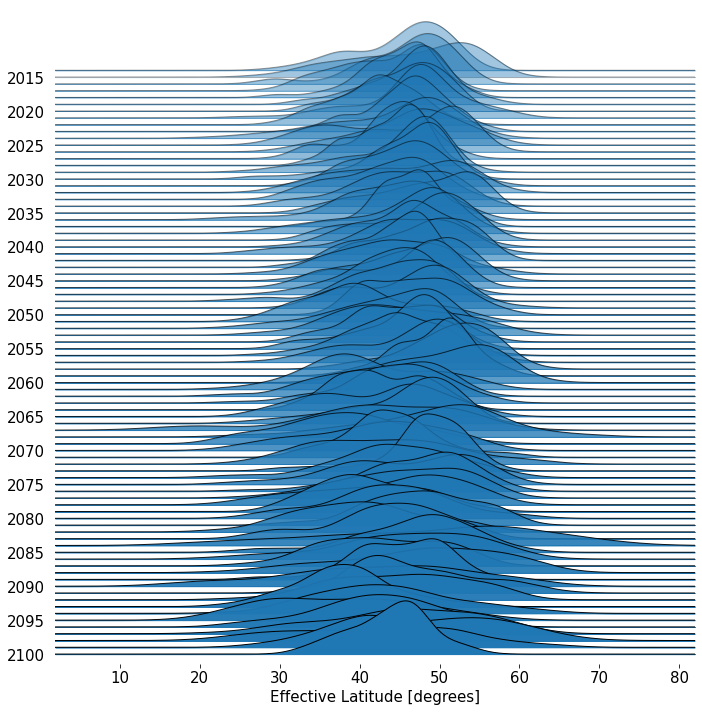

,year,eff_lat_deg
0,2014,49.548215
1,2014,49.815202
2,2014,47.448761
3,2014,47.801480
4,2014,48.265708
...,...,...
7736,2100,47.026832
7737,2100,46.489209
7738,2100,41.669904
7739,2100,46.305875


<Figure size 432x288 with 0 Axes>

In [51]:
joy_div(test_df,
        time_key='time',
        data_key='eff_lat_deg',
        decade=False)